# Diffusion models

*Nov 3, 2024*

**[Javad Komijani (ETH Zurich)](mailto:jkomijani@gmail.com)**

# Introduction

## Diffusion process

The diffusion process is described by a stochastic differential equation (SDE):
$$
  \frac{d}{dt} x_t = f(x_t) + \sigma \eta_t .
$$
Here, $x_t$ is the state of the system at diffusion time $t$,
$f(x_t)$ represents a deterministic drift term,
$\eta_t$ is a stochastic term, often modeled as a white Gaussian noise with
zero mean and unit variance.

By setting the drift term to zero, we can define a diffusion model in the
framework of machine learning, and train it by applying certain simple
algorithms as discussed below.
However, this choice increases the time required for the diffusion process to
lose information about the initial distribution.
A straightforward modification is to choose a non-vanishing drift term as
$f(x_t) = - \omega x_t$, which transforms the forward process into
$$
  \frac{d}{dt}\left(e^{\omega t} x_t\right) = e^{\omega t} \sigma \eta_t.
$$
This approach allows for the use of the same simple algorithms as those employed
in the case of vanishing drift, while also speeding up the loss of information
from the initial distribution.
The stochastic differential equation (SDE) can be solved in a closed form as
$$
  x_t = e^{-\omega t} x_0 + \sigma \sqrt{\frac{1 - e^{-2\omega t}}{2\omega}} \bar \eta_t,
$$
where $\bar \eta_t$ represents a normal variable with zero mean and unit variance.
We set $\sigma = \sqrt{2\omega}$ so that variance of $x_t$ approaches 1 at large
values of $t$, i.e., for $t \gg 1 / \omega$.

### Reverse of diffusion process

The diffusion process can be reversed; however, this reverse process is not unique.
This reverse operation is commonly referred to as denoising process.
Indeed there is a one-parameter family of denoising process:
$$
  \frac{d}{dt} x_t = f(x_t) - \frac{\sigma^2 + \tilde \sigma^2}{2}
  \partial_{x_t} \ln p_t(x_t) + \tilde\sigma \eta_t
$$
for any real value of $\tilde\sigma$.
A denoising process aims to recover alternative samples of the original data
from the diffused version by removing the noise that is introduced during
the diffusion process. A crucial aspect of the denoising process is
understanding the so-called score function, i.e., the gradient of
$\ln p_t(x_t)$.


Interestingly, when $\tilde\sigma = 0$, the denoising process simplifies to
a completely deterministic flow, which can be interpreted as a continuous
normalizing flow.

## Loss function

### Explicit and implicit score matching
Score matching is a technique used to train models to approximate the data distribution
$p(x)$ by minimizing the difference between the true score $\partial_x \ln p(x)$
and the model score function $s(x; \theta)$, where $\theta$ is used to denote
the model parameters.
To simplify the score matching problem, it is often more practical to work with
the conditional distribution $p(x|x_0)$ instead of directly using the marginal
distribution $p(x)$.

To this end, [Ref.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6795935)
shows that for a function $s(x; \theta)$ such that the following integrals are
finite, we have:
$$
    \int dx\, p(x)\,
    \left\lVert s(x; \theta) - \partial_x \log p(x)\right\rVert^2 
    =
    \int\int dx dx_0 \, p(x, x_0)\,
    \left\lVert s(x; \theta) - \partial_x \log p(x|x_0)\right\rVert^2
    + \text{constant}\, .
$$
To derive the above relation, one can use the following identity
$$
    \int dx\, p(x) \Big\langle s(x; \theta), \partial_x \log p(x)\Big\rangle
    =
    \int\int dx dx_0\, p(x, x_0) \Big\langle s(x; \theta), \partial_x \log p(x|x_0)\Big\rangle
$$
which itself can be derived from
$$
    \partial_x p(x)
    =
    \int d x_0\, p(x, x_0)\, \partial_x \log p(x|x_0)\,.
$$

Therefore, in score matching, the conditional probability distribution
$p(x|x_0)$ can be used instead of the marginal distribution $p(x)$.
A loss function with the conditional and marginal distributions are named
implicit and explicit score matching, respectively.
Note that the constant appearing the above relation, is not necessarily finite.
To make the loss function finite an appropriate weight function is needed,
as discussed below.

For further discussion, see equations (11-14) of [arXiv:2209.00796](https://arxiv.org/abs/2209.00796).


### Loss function as a weighted integral
For the diffusion process the loss function is typically defined as a weighted
integral over diffusion time:
$$
    \text{Loss} = \int_0^T dt\, \lambda(t)\,
    \mathbb{E} \left[\left\lVert s(t, X_t; \theta)
    - \partial_{X_t} \log p_t(X_t|X_0)\right\rVert^2\right] \,.
$$
The weight function is typically set to a particular form that in our
convention reads: $\lambda(t) = 1 - e^{-2\omega t}$. With this particular
weight we obtain
$$
    \sqrt{\lambda(t)}\, \partial_{x_t} \log p_t(x_t|x_0) = - \bar\eta_t\,.
$$
Moreover, it suprresses the contribution of the constant difference between
the explicit and implicit score matching as $t$ approaches zero,
i.e.,
$$
 \lim_{t\to 0} \lambda(t)\,
    \mathbb{E} \left[\left\lVert \partial_{X_t} \log p_t(X_t)\right\rVert^2
    - \left\lVert \partial_{X_t} \log p_t(X_t|X_0)\right\rVert^2\right] 
$$
is finite as $t \to 0$.


Notably, the introduced weight function vanishes at $𝑡 = 0$ and effectively
suppresses the contribution of the score function to the loss as $t\to 0$.
More precisely, we have:
$$
   \sqrt{\lambda(t)}\, s(t, \phi_t; \theta) ~\propto~ \sqrt{t}
$$
for $t \ll 1$.
Consequently, training based on this loss function alone gains limited direct
insight from the data when $t \ll 1$, relying instead on extrapolation to cover
this region.
To shift from extrapolation to interpolation, we can incorporate prior
knowledge of the score function at $t = 0$ by augmenting the loss
function as follows:
$$
    \text{Loss}_\text{aug} = \text{Loss}
    + C_0\, \mathbb{E} \left[\left\lVert s(0, X_0; \theta) - \partial_{X_0} \log p_0(X_0)\right\rVert^2\right] .
$$
While this augmentation may not be useful for many applications of diffusion models,
it can be readily applied in lattice field theory, where $\partial_{x_0} \log p_0(x_0)$
is analytically known.
Nevertheless, not only we do not observe any improvement by augmenting the loss function,
but also we see that it degrades the sampling quality. We need to investigate it further.
Therefore we abandon the idea for now and set $C_0$ to zero.

Another option for the weight function would be to set $\lambda(t) = \sqrt{1 - e^{-2\omega t}}$.

## *Reduced* score function
We also introduce a *reduced* score function as
$$
\bar{s}(t, x_t; \theta) = s(t, x_t; \theta) + x_t,
$$
where $\phi_t$ can be considered the negative of the true score function for
a normal variable with zero mean and unit variance.
The family of reverse diffusion processes then can be expressed as
$$
  \frac{d}{dt} x_t = - \omega\, \bar{s}(t, x_t; \theta)
  - \frac{\tilde \sigma^2}{2} s(t, x_t; \theta) + \tilde\sigma \eta_t
$$
for any real value of $\tilde\sigma$; notably, this expression depends only on
the reduced score function for the vanishing $\tilde\sigma$ case.


So far, we have introduced several parameters: $\omega$, $\sigma$, $T$,
and $\tilde{\sigma}$. Note that we have already fixed $\sigma = \sqrt{2\omega}$.
Among these parameters, $\tilde{\sigma}$ does not influence training efficiency.
Furthermore, by rescaling the diffusion time, we can set either $T$ or $\omega$
to unity; here, we choose $T = 1$.
We observe that $\omega = \pi$ is an effective choice, though $\omega$ can also
be treated as a tunable hyper-parameter for further refinement.

# Example

We now look at a scalar theory in zero dimension, i.e., a scenario with one point and one degree of freedom.
To compare our resulats with [arXiv:2309.17082], we investigate a distribution of form

$$
   p(x) \propto e^{-\frac{1}{2} m^2 x^2 - \lambda x^4}
$$
with $m^2 = -1$ and $\lambda = 1 / 60$.

## Data for training and test

We use `normlfow` package to generate samples for training the diffusion model and testing.
We use a pre-trained `normflow` model to generate $16 \times 1024$ samples, where 1024
samples will be used for training and the rest for making histograms.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["text.usetex"] = True

In [2]:
from normflow import Model as NormflowModel
from normflow.action import ScalarPhi4Action
from normflow.prior import NormalPrior
from normflow.nn import DistConvertor_

In [3]:
def make_normflow_model():
    # Define the prior distribution
    prior = NormalPrior(shape=(1,))
    
    # Define the action for a scalar \phi^4 theory
    action = ScalarPhi4Action(kappa=None, m_sq=-1, lambd=1/60)
    
    # Initialize the neural network for transformations
    net_ = DistConvertor_(knots_len=20, symmetric=True)
    
    # Create the Model with the defined components
    nf_model = NormflowModel(net_=net_, prior=prior, action=action)
    
    return nf_model


# Instantiate the model
nf_model = make_normflow_model()

In [4]:
train_the_model = False

if train_the_model:
    nf_model.train(n_epochs=5000, batch_size=1024, checkpoint_dict=dict(print_stride=100))

else:
    weights_blob = 'UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYCwAAADEud2VpZ2h0c194cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgBAAAAMHEGWAMAAABjcHVxB0sTdHEIUUsASxOFcQlLAYVxColoAClScQt0cQxScQ1YCwAAADEud2VpZ2h0c195cQ5oAygoaARoBVgBAAAAMXEPaAdLE3RxEFFLAEsThXERSwGFcRKJaAApUnETdHEUUnEVWAsAAAAxLndlaWdodHNfZHEWaAMoKGgEaAVYAQAAADJxF2gHSxR0cRhRSwBLFIVxGUsBhXEaiWgAKVJxG3RxHFJxHXV9cR5YCQAAAF9tZXRhZGF0YXEfaAApUnEgKFgAAAAAcSF9cSJYBwAAAHZlcnNpb25xI0sBc1gBAAAAMHEkfXElaCNLAXNYAQAAADFxJn1xJ2gjSwFzWAkAAAAxLnNvZnRtYXhxKH1xKWgjSwFzWAoAAAAxLnNvZnRwbHVzcSp9cStoI0sBc1gBAAAAMnEsfXEtaCNLAXN1c2IuUEsHCI8kDTrQAQAA0AEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAEQAxAGFyY2hpdmUvYnl0ZW9yZGVyRkItAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmxpdHRsZVBLBwiFPeMZBgAAAAYAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4APgBhcmNoaXZlL2RhdGEvMEZCOgBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpat2qkZzuh/7+jSYgIam//v31JeHGARP6/HLX+oenW/L/SPkE80Pj5v/rlTTAQZPa/TLSCJbLx8b9Hx8EnJ0jqv6+Hdt12i+C/gZplmFmNzL/bbw74sRaev2rJswplE8o/cAyivZ174D8jWiQ8/O/sP7Y67RBpZvQ/BsWlb0hf+T+XFXdQDcD8P2WDSxYQI/0/eEhOCFRa9j9QSwcIrNs0EZgAAACYAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOACwAYXJjaGl2ZS9kYXRhLzFGQigAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWok3h+VyDfc/FSB2Zmrb9j+c8kjudLL2P/wLsuzWGPU/POnwxZbs8T/oXPRIdcTqP0txOvcR5uI/23vbGIs31T9XG0Ecla+7P72MUC0bt76/mg2IYNoF2r8yb8yLoXfjvyre5Yvh/+a/qxGX9aSP6L+UQEGOQjvrv8lxT0OuK++/AQH+7PbY8b9/Xv1/3v7zv447XjKrevO/UEsHCL7uq8mYAAAAmAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAsAGFyY2hpdmUvZGF0YS8yRkIoAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrYr915h98JQHNXMFJwxQpAt6VmEU70CkDlYzGGD2MLQIPyj23jdwxAi63muf+qDUAwmC0gdFcOQED+aqTqMQxAU7mmqC8xA0BMxrNJPGDwP3Onicy8v7a/CjojkiuL7b8edK4Mk0T6v2EY138tlgLAVWILViYVCMABTbuMuloNwFD68OlS2RDAZhT+rwIEEsA7d4rPG8YQwAtsfZjrZvq/UEsHCKZ25lSgAAAAoAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvdmVyc2lvbkZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMwpQSwcI0Z5nVQIAAAACAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAeADIAYXJjaGl2ZS8uZGF0YS9zZXJpYWxpemF0aW9uX2lkRkIuAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlowNzIxMjY2NTk3NDg4NjkyNjU4NjAzOTM4MTIwNzE3MDk1MjAwODc3UEsHCP3q99YoAAAAKAAAAFBLAQIAAAAACAgAAAAAAACPJA060AEAANABAAAQAAAAAAAAAAAAAAAAAAAAAABhcmNoaXZlL2RhdGEucGtsUEsBAgAAAAAICAAAAAAAAIU94xkGAAAABgAAABEAAAAAAAAAAAAAAAAAIAIAAGFyY2hpdmUvYnl0ZW9yZGVyUEsBAgAAAAAICAAAAAAAAKzbNBGYAAAAmAAAAA4AAAAAAAAAAAAAAAAAlgIAAGFyY2hpdmUvZGF0YS8wUEsBAgAAAAAICAAAAAAAAL7uq8mYAAAAmAAAAA4AAAAAAAAAAAAAAAAAqAMAAGFyY2hpdmUvZGF0YS8xUEsBAgAAAAAICAAAAAAAAKZ25lSgAAAAoAAAAA4AAAAAAAAAAAAAAAAAqAQAAGFyY2hpdmUvZGF0YS8yUEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAsAUAAGFyY2hpdmUvdmVyc2lvblBLAQIAAAAACAgAAAAAAAD96vfWKAAAACgAAAAeAAAAAAAAAAAAAAAAABIGAABhcmNoaXZlLy5kYXRhL3NlcmlhbGl6YXRpb25faWRQSwYGLAAAAAAAAAAeAy0AAAAAAAAAAAAHAAAAAAAAAAcAAAAAAAAAugEAAAAAAAC4BgAAAAAAAFBLBgcAAAAAcggAAAAAAAABAAAAUEsFBgAAAAAHAAcAugEAALgGAAAAAA=='
    nf_model.net_.set_weights_blob(weights_blob)

#### Create a data loader for training the diffusion model

In [5]:
# Generate 16 * 1024 samples, use 1024 for training and use the rest for making histograms
nf_samples = nf_model.mcmc.sample(1024 * 16)

print("acceptance rate of normflow model: %.4g" % nf_model.mcmc.history.accept_rate[-1])


# use 1024 for training 
training_samples = nf_samples[1024::15]
print("shape of training data", training_samples.shape)

acceptance rate of normflow model: 0.9622
shape of training data torch.Size([1024, 1])


In [6]:
from torch.utils.data import Dataset, DataLoader,TensorDataset

batch_size = 256

dataset = TensorDataset(training_samples)
data_loader = DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle = False
)

## Creating and training a diffusion model

Similar to [normflow](https://github.com/jkomijani/normflow) package,
one should provide three essential components for a diffusion model:

*   A **prior distribution** to draw initial samples in the reverse process for
    genearting samples.
*   A **diffusion process**, which consists of neural network that models
    **reduced score function**, which can be used to perform the reverse process.
*   An **action** that specifies the target distribution, defining the goal of the generative model.
  
The central high-level class of the package is called `Model`, which can be instantiated by
providing instances of the three objects mentioned above as


```python
Model(
    prior = prior,
    diffusion_process = DiffusionProcess(reduced_score_func),
    action = action
    )
```

Unlike the functions used in the method of normalizing flows,
**reduced score function** does not need to be invertible.

Before we continue, let us create a dummy `DiffusionProcess` without any score
function and see the effect of the diffusion process.

In [7]:
from diffusion_model import DiffusionProcess

diff_proc = DiffusionProcess()

t_eval = np.linspace(0, 1, 200)

diffused_samples = diff_proc.run_diffusion_process(nf_samples, t_eval=t_eval)

In [8]:
# Useful for plotting:


grab = lambda x: x.detach().cpu().numpy()


def calc_normalized_probability(nf_model, x_0):
    h = x_0[1] - x_0[0]  # assume x_0 items are equidiatnat
    action = nf_model.action(x_0[:, None])
    return torch.exp(-action - torch.logsumexp(-action, dim=0)) / h


diffused_samples = np.array([grab(q) for q in diffused_samples])

t_eval = np.tile(t_eval[:, None], (1, diffused_samples.shape[1]))

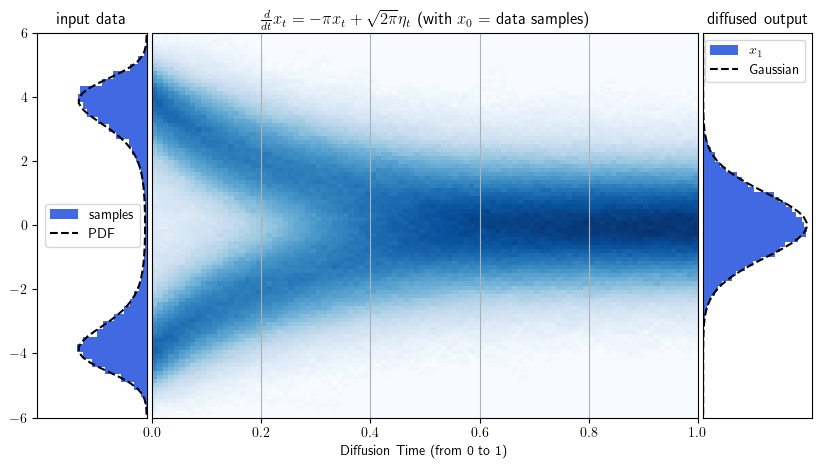

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'width_ratios': [0.2, 1, 0.2]})

axs[1].hist2d(t_eval.ravel(), diffused_samples.ravel(), norm=mpl.colors.PowerNorm(0.5), cmap='Blues', bins=100);

hist_kwargs = dict(bins=50, color='royalblue', density=True, orientation='horizontal')
axs[0].hist(diffused_samples[0], label="samples", **hist_kwargs)
axs[2].hist(diffused_samples[-1], label=r"$x_1$", **hist_kwargs)
axs[0].invert_xaxis()  # Invert x-axis to place histogram to the left

# Add
x_0 = torch.linspace(-8.0, 8.0, 100)
axs[0].plot(grab(calc_normalized_probability(nf_model, x_0)), grab(x_0), '--k', label="PDF")
axs[2].plot(grab(torch.exp(-x_0**2 / 2)) / (2*np.pi)**0.5, grab(x_0), '--k', label="Gaussian")

# Remove undesired axis ticks and labels
axs[1].set_yticks([])
axs[2].set_yticks([])
axs[0].set_xticks([])
axs[2].set_xticks([])

# Add title
axs[0].set_title("input data")
axs[1].set_title(r"$\frac{d}{dt}  x_t = -\pi x_t + \sqrt{2\pi} \eta_t$  (with $x_0 = $ data samples)")
axs[2].set_title("diffused output")

# Set ylim
axs[0].set_ylim([-6, 6])
axs[1].set_ylim([-6, 6])
axs[2].set_ylim([-6, 6])
axs[0].set_xlim([0.42, 0])
axs[2].set_xlim([0, 0.42])

# Decrease horizontal spacing between subplots
plt.subplots_adjust(wspace=0.02)

# Add legend
axs[0].legend()
axs[1].grid()
axs[2].legend()

axs[1].set_xlabel(r'Diffusion Time (from 0 to 1)');

fig.savefig("diffusion_process.jpg")

### Designing (reduced) score functions

We now give a simple neural networ for the reduced score function and a more
advanced one based on *time embedding*. We will see that the simple one
performs in general even better that the time-embedded one in the case of
1 degree of freedom, but for higher dimensional problems one should use
time embedded neural networks.

In [10]:
class SimpleFunc(torch.nn.Sequential):
    """A simple (reduced) score function implemented using dense layers."""
    
    def __init__(self, hidden_sizes=[16, 16, 16]):

        in_features = 2  # for (t, x)
        out_features = 1  # for (score)
        
        sizes = [in_features, *hidden_sizes, out_features]
        
        nets = []
        
        for ind in range(len(hidden_sizes) + 1):
            nets.append(torch.nn.Linear(sizes[ind], sizes[ind + 1]))
            if ind < len(hidden_sizes):
                nets.append(torch.nn.SiLU())
            
        super().__init__(*nets)
        
    def forward(self, t, x):            
        return super().forward(torch.cat([t[:, None], x], dim=-1))

In [11]:
class SinosoidalTimeEmbedding(torch.nn.Module):
    """Following "Attension is all you need", this class yields a sinosoidal    
    time (position) embedding. Unlike the mentioned papar, in which position is 
    integer, we are interested in the case that time is not integer and in fact 
    it is not larger than one; therefore, we use a different setting, which can
    be controlled by changing `max_freq` and `base`.                            
    """ 
    
    def __init__(self,
                 embed_len: int,
                 max_freq: float = 10,
                 base: float = 1000,
                 random_freq: bool = False
                ):
        super().__init__()

        assert embed_len % 2 == 0
        self.embed_len = embed_len
        
        if random_freq:
            power = torch.rand(embed_len // 2)
        else:
            power = torch.linspace(0, 1, embed_len // 2)

        self.freq = max_freq / base**power
        
    def forward(self, time):
        phase = 2 * np.pi * time[:, None] * self.freq[None, :]
        time_embedded = torch.zeros(
            [len(time), self.embed_len], device=time.device
        )
        time_embedded[:, 0::2] = torch.sin(phase)
        time_embedded[:, 1::2] = torch.cos(phase)
        return time_embedded
      

class TimeEmbeddedFunc(torch.nn.Module):
    """A time-embedded (reduced) score function designed following
    [arXiv: 2309.17082]
    """
    
    def __init__(self, hidden_features=64, embed_len=64):
        super().__init__()
               
        self.encoder = torch.nn.Linear(1, hidden_features)
        
        self.decoder = torch.nn.Linear(hidden_features, 1)
    
        self.act = torch.nn.SiLU()

        self.time_embeder = torch.nn.Sequential(
            SinosoidalTimeEmbedding(embed_len=embed_len),
            torch.nn.Linear(embed_len, embed_len),
            torch.nn.SiLU(),
            torch.nn.Linear(embed_len, hidden_features)
            )
        
    def forward(self, t: torch.Tensor, x: torch.Tensor):
        x = self.encoder(x)
        x = self.act(x + self.time_embeder(t))
        x = self.decoder(x)
        return x

In [12]:
# Now the build the model

from diffusion_model import Model


def make_diffusion_model(use_time_embedding=True):
    if use_time_embedding:
        reduced_score_func = TimeEmbeddedFunc()
    else:
        reduced_score_func = SimpleFunc()
    return Model(
        prior = nf_model.prior,
        action = nf_model.action,
        diffusion_process = DiffusionProcess(reduced_score_func)
    )

In [13]:
from functools import partial

n_epochs = 1000

fit_kwargs = dict(
    n_epochs = n_epochs,
    hyperparam = dict(lr=0.003, betas=(0.9, 0.99)),
    checkpoint_dict = dict(print_stride=n_epochs // 20),
    scheduler = partial(
                torch.optim.lr_scheduler.CosineAnnealingLR,                     
                T_max = int(1.001 * n_epochs)                                    
                )
)

diffusion_model0 = make_diffusion_model(use_time_embedding=False)
diffusion_model0.train(data_loader, **fit_kwargs)

diffusion_model1 = make_diffusion_model(use_time_embedding=True)
diffusion_model1.train(data_loader, **fit_kwargs)

>>> Training started for 1000 epochs <<<
Epoch: 1 | loss: 1.0999
Epoch: 50 | loss: 0.3766
Epoch: 100 | loss: 0.3189
Epoch: 150 | loss: 0.2871
Epoch: 200 | loss: 0.2861
Epoch: 250 | loss: 0.3104
Epoch: 300 | loss: 0.3046
Epoch: 350 | loss: 0.3023
Epoch: 400 | loss: 0.3646
Epoch: 450 | loss: 0.3060
Epoch: 500 | loss: 0.3746
Epoch: 550 | loss: 0.2669
Epoch: 600 | loss: 0.3235
Epoch: 650 | loss: 0.3298
Epoch: 700 | loss: 0.3559
Epoch: 750 | loss: 0.2903
Epoch: 800 | loss: 0.3021
Epoch: 850 | loss: 0.3301
Epoch: 900 | loss: 0.3156
Epoch: 950 | loss: 0.2989
Epoch: 1000 | loss: 0.3144
>>> Training finished (cpu); TIME = 18.6 sec <<<
>>> Training started for 1000 epochs <<<
Epoch: 1 | loss: 1.6403
Epoch: 50 | loss: 0.3178
Epoch: 100 | loss: 0.4216
Epoch: 150 | loss: 0.3385
Epoch: 200 | loss: 0.3371
Epoch: 250 | loss: 0.3050
Epoch: 300 | loss: 0.3126
Epoch: 350 | loss: 0.3326
Epoch: 400 | loss: 0.2830
Epoch: 450 | loss: 0.3768
Epoch: 500 | loss: 0.2944
Epoch: 550 | loss: 0.3333
Epoch: 600 | los

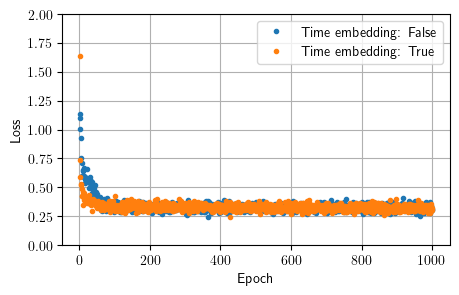

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))

loss = diffusion_model0.train.train_history['loss'][1:]
epochs = np.arange(1, len(loss) + 1)
plt.plot(epochs, loss, '.', label=r'Time embedding: False')

loss = diffusion_model1.train.train_history['loss'][1:]
epochs = np.arange(1, len(loss) + 1)
plt.plot(epochs, loss, '.', label=r'Time embedding: True')

# plt.xlim([0, 200])
plt.ylim([0, 2])
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

In [15]:
x = diffusion_model0.prior.sample(1024 * 16)
dm0_samples = diffusion_model0.denoising_flow.forward(x)
dm1_samples = diffusion_model1.denoising_flow.forward(x)

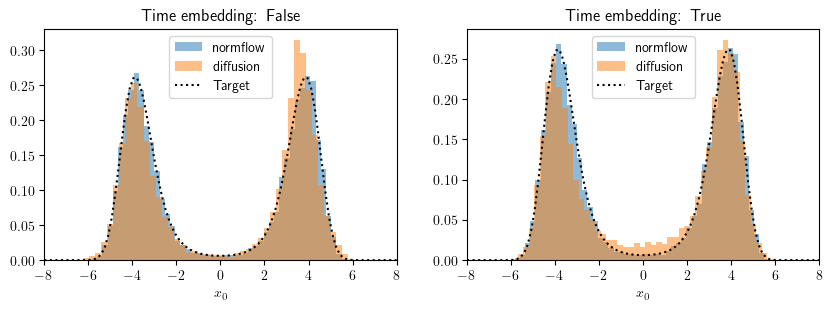

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

for ind, dm in enumerate([dm0_samples, dm1_samples]):
    
    kwargs = dict(bins=50, alpha=0.5, density=True)
    axs[ind].hist(grab(nf_samples.ravel()), label = 'normflow', **kwargs)
    
    axs[ind].hist(grab(dm.ravel()), label=f"diffusion" , **kwargs)

    x_0 = torch.linspace(-8.0, 8.0, 100)
    axs[ind].plot(grab(x_0), grab(calc_normalized_probability(nf_model, x_0)), ':k', label="Target")

    axs[ind].set_title(f"Time embedding: {bool(ind)}")
    axs[ind].set_xlabel(r'$x_0$')
    axs[ind].set_xlim([-8, 8])
    axs[ind].legend()

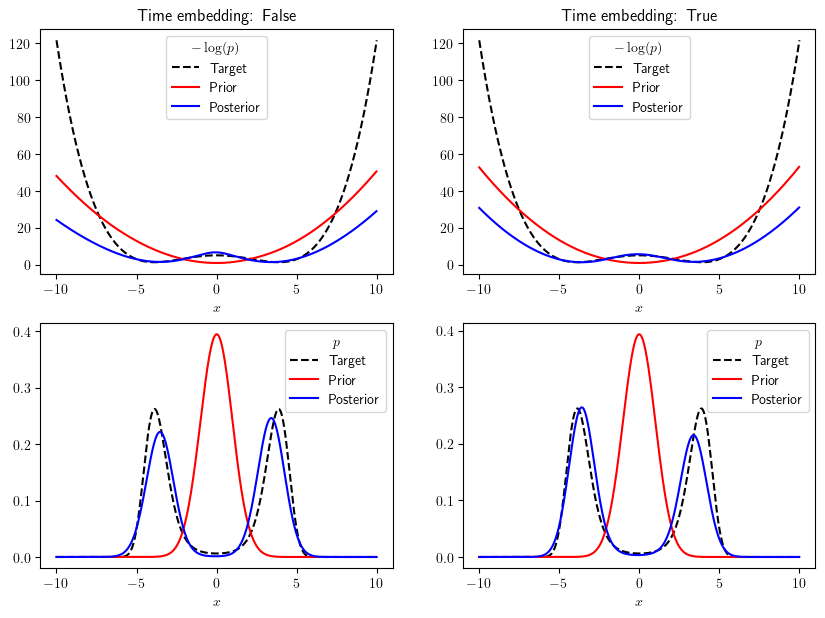

In [17]:
n_t = 1000
n_x = 1000

t_linspace = torch.linspace(1, 0, n_t)  # for reverse process
x_0 = torch.linspace(-10.0, 10.0, n_x)[:, None]
h = x_0[1] - x_0[0]


def normalize_action(action):
    return action + torch.logsumexp(-action, dim=0) + torch.log(h)


@torch.no_grad
def calc_effective_action(diffusion_model, t, x):
    t =  t[None].repeat(x.shape[0])
    score = diffusion_model.diffusion_process.reduced_score_func(t, x) - x
    logq = h * 0.5 * (score[:-1] + score[1:]).cumsum(0)
    return normalize_action(-logq)[:, 0]


eff_actions0 = np.zeros([n_x - 1, n_t]) 
eff_actions1 = np.zeros([n_x - 1, n_t]) 


for ind, t in enumerate(t_linspace):
    eff_actions0[:, ind] = grab(calc_effective_action(diffusion_model0, t, x_0))
    eff_actions1[:, ind] = grab(calc_effective_action(diffusion_model1, t, x_0))


fig, axs = plt.subplots(2, 2, figsize=(10, 7))


for ind, eff_actions in enumerate([eff_actions0, eff_actions1]):
   
    action = grab(normalize_action(nf_model.action(x_0)))
    axs[0][ind].plot(grab(x_0), action, '--k', label = 'Target')
    axs[1][ind].plot(grab(x_0), np.exp(-action), '--k', label = 'Target')

    axs[0][ind].plot(grab(x_0)[:-1], eff_actions[:, 0], color = 'r', label = 'Prior')
    axs[1][ind].plot(grab(x_0)[:-1], np.exp(-eff_actions[:, 0]), color = 'r', label = 'Prior')

    axs[0][ind].plot(grab(x_0)[:-1], eff_actions[:, -1], color = 'b', label = 'Posterior')
    axs[1][ind].plot(grab(x_0)[:-1], np.exp(- eff_actions[:, -1]), color = 'b', label = 'Posterior')

    axs[0][ind].set_title(f"Time embedding: {bool(ind)}")
    
    axs[0][ind].set_xlabel(r'$x$')
    axs[1][ind].set_xlabel(r'$x$')

    axs[0][ind].legend(title=r"$-\log(p)$")
    axs[1][ind].legend(title=r"$p$")

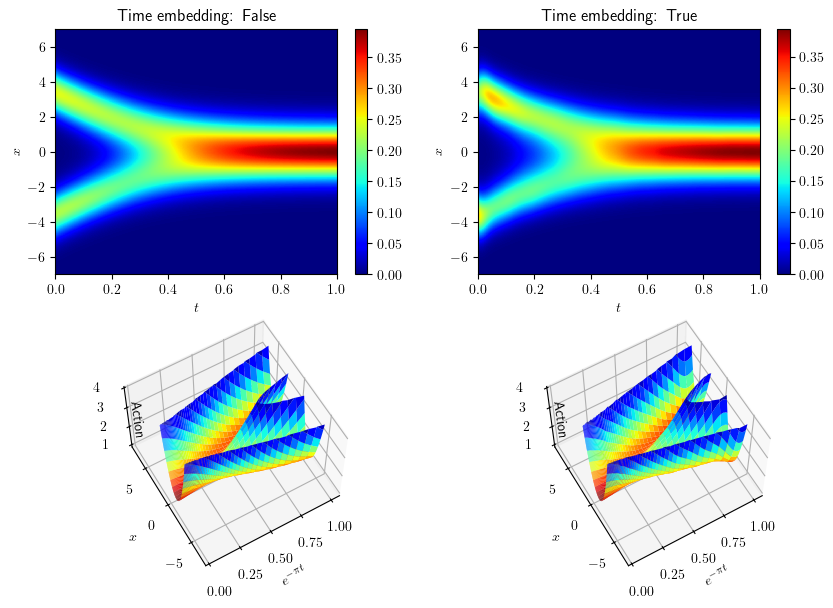

In [18]:
t_linspace = grab(t_linspace)
x_0 = grab(x_0)

T, X = np.meshgrid(t_linspace, 0.5 * (x_0[:-1] + x_0[1:])[150: 850])

fig = plt.figure(figsize=(10, 7))

axs = [
    [fig.add_subplot(2, 2, 1), fig.add_subplot(2, 2, 2)],
    [fig.add_subplot(2, 2, 3, projection='3d'), fig.add_subplot(2, 2, 4, projection='3d')]
]


for ind, eff_actions in enumerate([eff_actions0, eff_actions1]):

    Z = eff_actions[150: 850]

    pcm = axs[0][ind].pcolormesh(T, X, np.exp(-Z), cmap='jet', shading='auto')
    fig.colorbar(pcm, ax=axs[0][ind])

    axs[0][ind].set_xlabel('$\phi$')
    axs[0][ind].set_ylabel(r'$t$')

    Z [ Z > 4 ] = np.nan

    axs[1][ind].plot_surface(np.exp(-np.pi * T), X, Z, cmap='jet_r', antialiased=True)
    
    axs[0][ind].set_title(f"Time embedding: {bool(ind)}")
    
    axs[0][ind].set_xlabel('$t$')
    axs[1][ind].set_xlabel(r'$e^{-\pi t}$')

    axs[0][ind].set_ylabel(r'$x$')
    axs[1][ind].set_ylabel(r'$x$')
    
    axs[1][ind].set_zlabel('Action', labelpad=-25)
    axs[1][ind].view_init(60, -120)